<a href="https://colab.research.google.com/github/RegisKonan/FinalProject/blob/main/Regis_konan_Model_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt

## Load FashionMNIST dataset from torchvision


In [9]:
# MNIST dataset 
batch_size = 64
train_dataset = torchvision.datasets.FashionMNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

examples = iter(test_loader)
example_data, example_targets = next(examples)
print(example_data.shape)
print(example_targets)

torch.Size([64, 1, 28, 28])
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5])


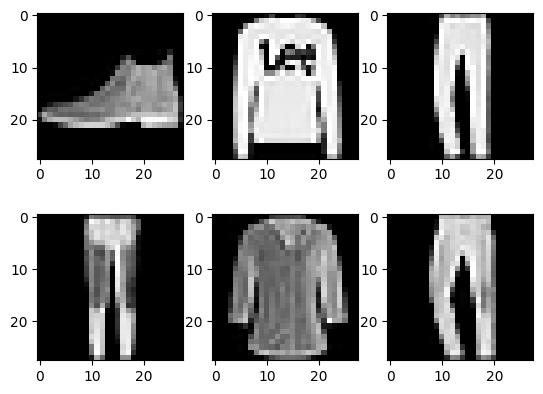

In [10]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

## Define the Model using torch nn Module

In [11]:
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [12]:
model = Classifier()

images, labels = next(iter(test_loader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


## Train model

In [13]:
model = Classifier()
criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30

train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        tot_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    else:
        tot_test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in test_loader:
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        # Get mean loss to enable comparison between train and test sets
        train_loss = tot_train_loss / len(train_loader.dataset)
        test_loss = tot_test_loss / len(test_loader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(test_loader.dataset)))

Epoch: 1/30..  Training Loss: 0.524..  Test Loss: 0.424..  Test Accuracy: 0.850
Epoch: 2/30..  Training Loss: 0.373..  Test Loss: 0.450..  Test Accuracy: 0.841
Epoch: 3/30..  Training Loss: 0.347..  Test Loss: 0.378..  Test Accuracy: 0.864
Epoch: 4/30..  Training Loss: 0.320..  Test Loss: 0.395..  Test Accuracy: 0.864
Epoch: 5/30..  Training Loss: 0.302..  Test Loss: 0.381..  Test Accuracy: 0.863
Epoch: 6/30..  Training Loss: 0.293..  Test Loss: 0.370..  Test Accuracy: 0.867
Epoch: 7/30..  Training Loss: 0.282..  Test Loss: 0.346..  Test Accuracy: 0.879
Epoch: 8/30..  Training Loss: 0.272..  Test Loss: 0.353..  Test Accuracy: 0.873
Epoch: 9/30..  Training Loss: 0.262..  Test Loss: 0.355..  Test Accuracy: 0.879
Epoch: 10/30..  Training Loss: 0.257..  Test Loss: 0.371..  Test Accuracy: 0.869
Epoch: 11/30..  Training Loss: 0.253..  Test Loss: 0.352..  Test Accuracy: 0.881
Epoch: 12/30..  Training Loss: 0.243..  Test Loss: 0.344..  Test Accuracy: 0.883
Epoch: 13/30..  Training Loss: 0.237.

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

## Plot the training and test loss

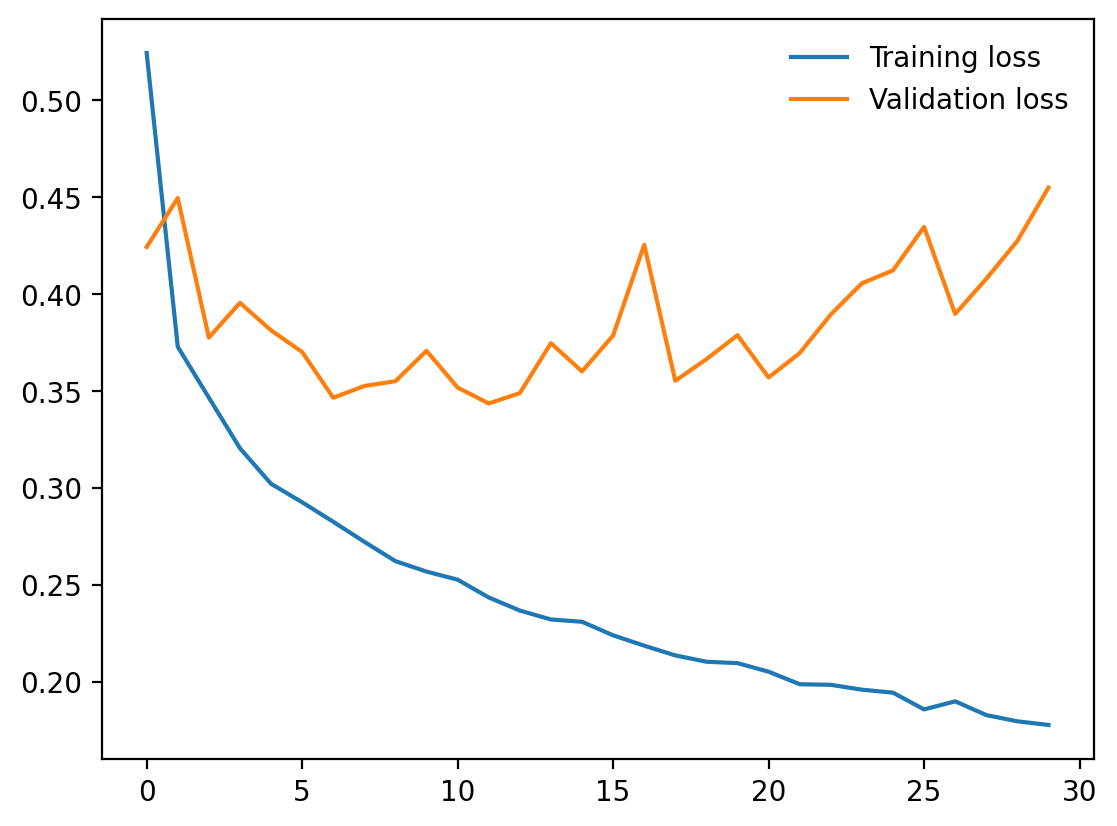

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Add weight decay regularization

In [16]:
model = Classifier()
criterion = nn.NLLLoss()

## define our weight decay
weight_decay =1e-4
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay= weight_decay)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:       
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in test_loader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/30..  Training Loss: 0.516..  Test Loss: 0.440..  Test Accuracy: 0.844
Epoch: 2/30..  Training Loss: 0.391..  Test Loss: 0.402..  Test Accuracy: 0.854
Epoch: 3/30..  Training Loss: 0.359..  Test Loss: 0.383..  Test Accuracy: 0.861
Epoch: 4/30..  Training Loss: 0.343..  Test Loss: 0.405..  Test Accuracy: 0.850
Epoch: 5/30..  Training Loss: 0.331..  Test Loss: 0.381..  Test Accuracy: 0.862
Epoch: 6/30..  Training Loss: 0.324..  Test Loss: 0.363..  Test Accuracy: 0.869
Epoch: 7/30..  Training Loss: 0.312..  Test Loss: 0.385..  Test Accuracy: 0.861
Epoch: 8/30..  Training Loss: 0.310..  Test Loss: 0.395..  Test Accuracy: 0.854
Epoch: 9/30..  Training Loss: 0.301..  Test Loss: 0.371..  Test Accuracy: 0.871
Epoch: 10/30..  Training Loss: 0.298..  Test Loss: 0.361..  Test Accuracy: 0.869
Epoch: 11/30..  Training Loss: 0.294..  Test Loss: 0.423..  Test Accuracy: 0.854
Epoch: 12/30..  Training Loss: 0.291..  Test Loss: 0.364..  Test Accuracy: 0.867
Epoch: 13/30..  Training Loss: 0.287.

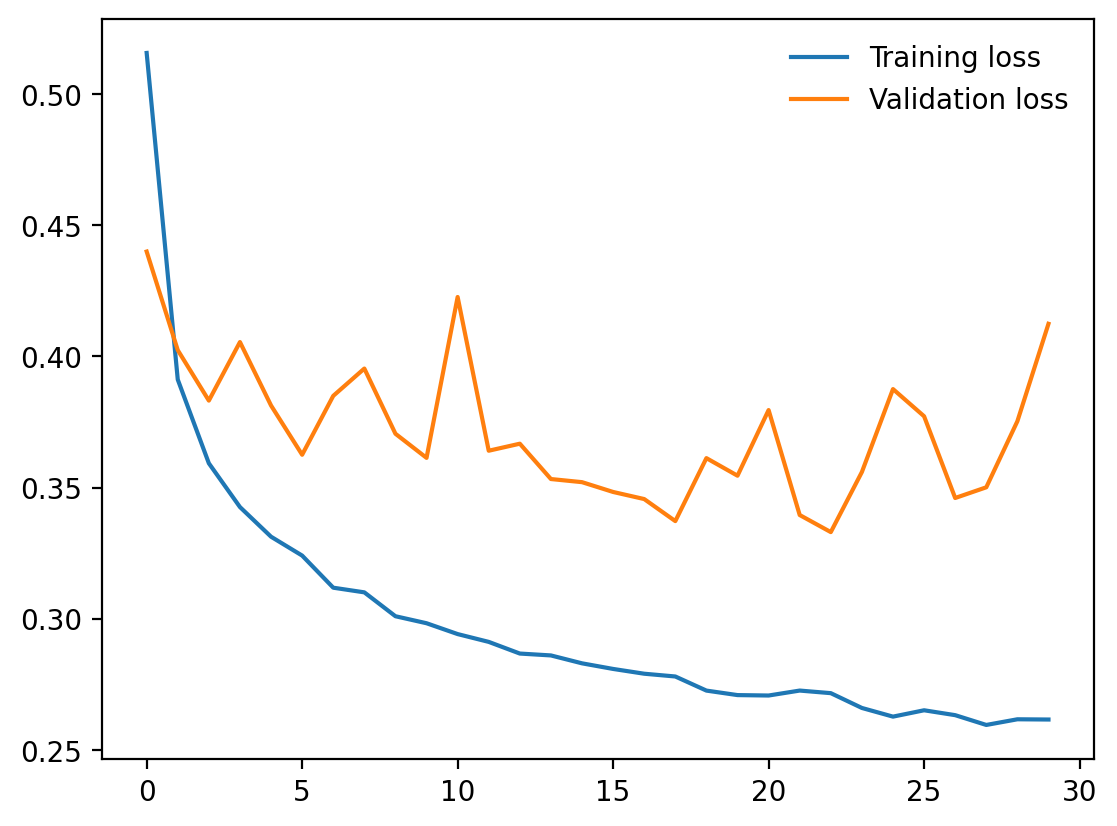

In [17]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Add dropout

In [18]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [19]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in test_loader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/30..  Training Loss: 0.604..  Test Loss: 0.443..  Test Accuracy: 0.834
Epoch: 2/30..  Training Loss: 0.455..  Test Loss: 0.423..  Test Accuracy: 0.849
Epoch: 3/30..  Training Loss: 0.422..  Test Loss: 0.387..  Test Accuracy: 0.856
Epoch: 4/30..  Training Loss: 0.402..  Test Loss: 0.384..  Test Accuracy: 0.862
Epoch: 5/30..  Training Loss: 0.387..  Test Loss: 0.389..  Test Accuracy: 0.869
Epoch: 6/30..  Training Loss: 0.380..  Test Loss: 0.381..  Test Accuracy: 0.865
Epoch: 7/30..  Training Loss: 0.372..  Test Loss: 0.378..  Test Accuracy: 0.865
Epoch: 8/30..  Training Loss: 0.362..  Test Loss: 0.389..  Test Accuracy: 0.861
Epoch: 9/30..  Training Loss: 0.363..  Test Loss: 0.379..  Test Accuracy: 0.872
Epoch: 10/30..  Training Loss: 0.354..  Test Loss: 0.353..  Test Accuracy: 0.873
Epoch: 11/30..  Training Loss: 0.344..  Test Loss: 0.372..  Test Accuracy: 0.874
Epoch: 12/30..  Training Loss: 0.344..  Test Loss: 0.358..  Test Accuracy: 0.873
Epoch: 13/30..  Training Loss: 0.341.

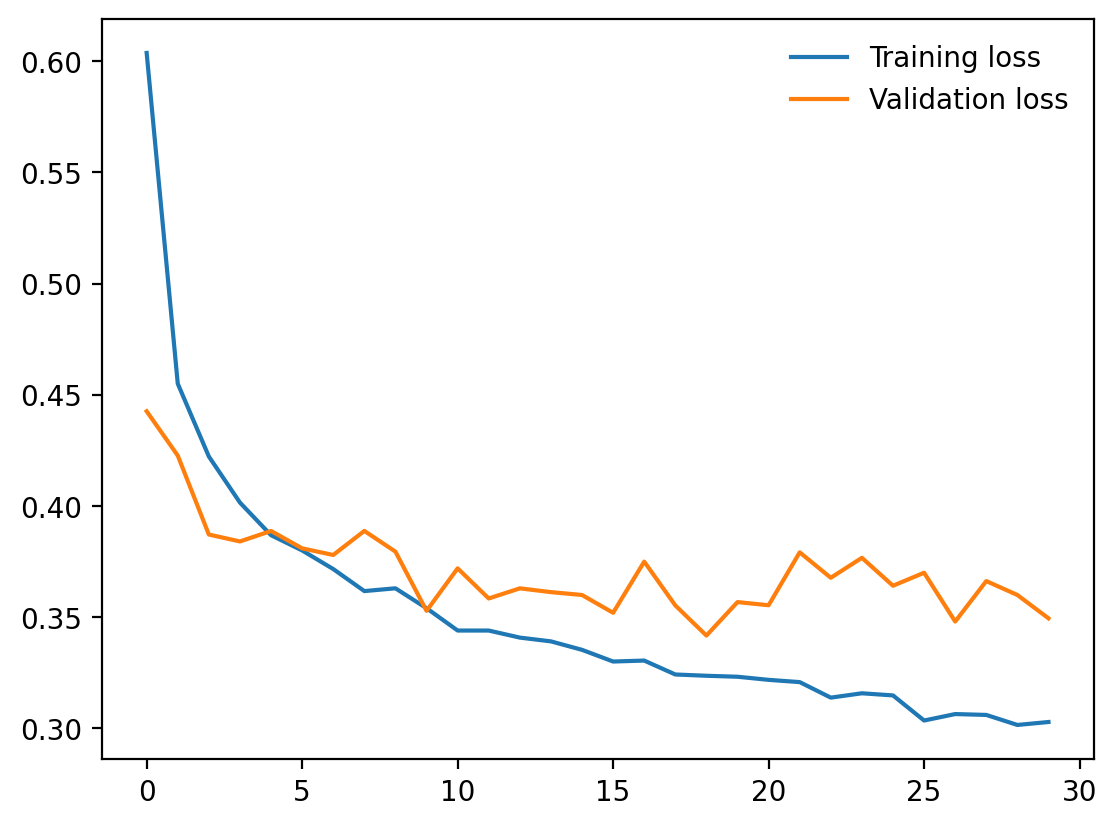

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

##Other approaches to prevent overfitting also include 

* Data Normalization
* Data Augmentation
* Early stopping

In [21]:
torch.save(model.state_dict(), 'model_weights.pth')

In [22]:
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>